In [15]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydicom import read_file
import scanpy as sc
import copy
import sys
sys.path.insert(0, '/home/olle/PycharmProjects/LODE/feature_segmentation/utils')

import plotting
plt.style.use('seaborn')

data_file = "/home/olle/PycharmProjects/LODE/workspace/sequence_data/longitudinal_properties_naive.csv"
data_pd = pd.read_csv(data_file)
oct_meta_pd = pd.read_csv("/home/olle/PycharmProjects/LODE/workspace/sequence_data/oct_meta_information.csv")

#### add patient id and lateraliy
data_pd["patient_id"] = data_pd.sequence.str.split("_", expand=True)[0]
data_pd["laterality"] = data_pd.sequence.str.split("_", expand=True)[1]

In [17]:
# Packages you'll use in the function
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Define function to output plot of the model coefficients

def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    #coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    # sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

#### How many sequence are treated?

In [18]:
print(f"number of treated sequences {data_pd.shape[0]}")

number of treated sequences 424


#### Insertion type distribution

Text(0.5, 1.0, 'month 24')

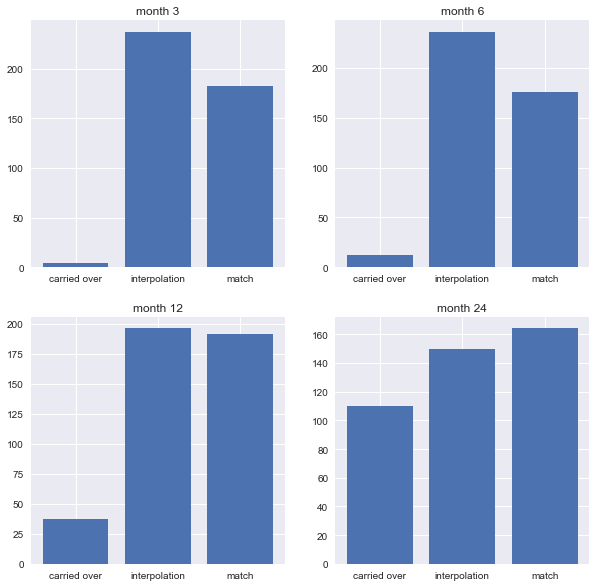

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

month_3 = data_pd.groupby(['insertion_type_3']).size().tolist()
month_6 = data_pd.groupby(['insertion_type_6']).size().tolist()
month_12 = data_pd.groupby(['insertion_type_12']).size().tolist()
month_24 = data_pd.groupby(['insertion_type_24']).size().tolist()

x_labels = ["carried over", "interpolation", "match"]

ax1.bar(x_labels, month_3,align='center')
ax1.set_title("month 3")
ax2.bar(x_labels,month_6,align='center')
ax2.set_title("month 6")
ax3.bar(x_labels,month_12,align='center')
ax3.set_title("month 12")
ax4.bar(x_labels,month_24,align='center')
ax4.set_title("month 24")

### carried over time distribution

/home/olle/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/olle/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Time from carry over 6 months')

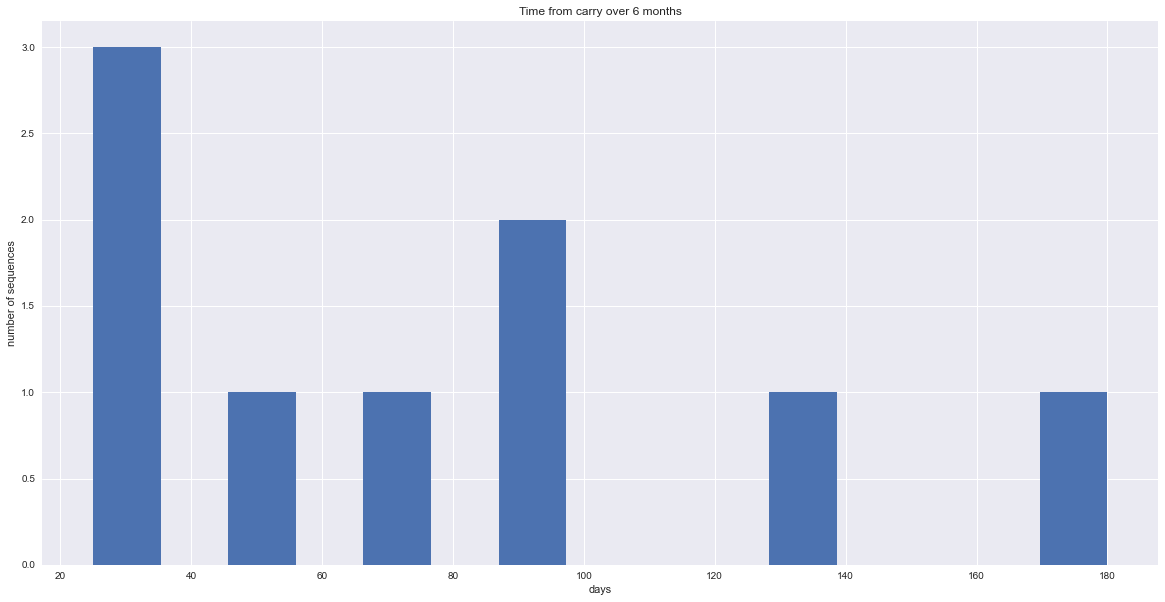

In [20]:
plt.figure(figsize=(20,10))
month_6_carry_over = data_pd.loc[data_pd.insertion_type_6 == "carry_over"]
plt.hist(month_6_carry_over.time_range_6, bins = 15)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from carry over 6 months")

Text(0.5, 1.0, 'Time from carry over 12 months')

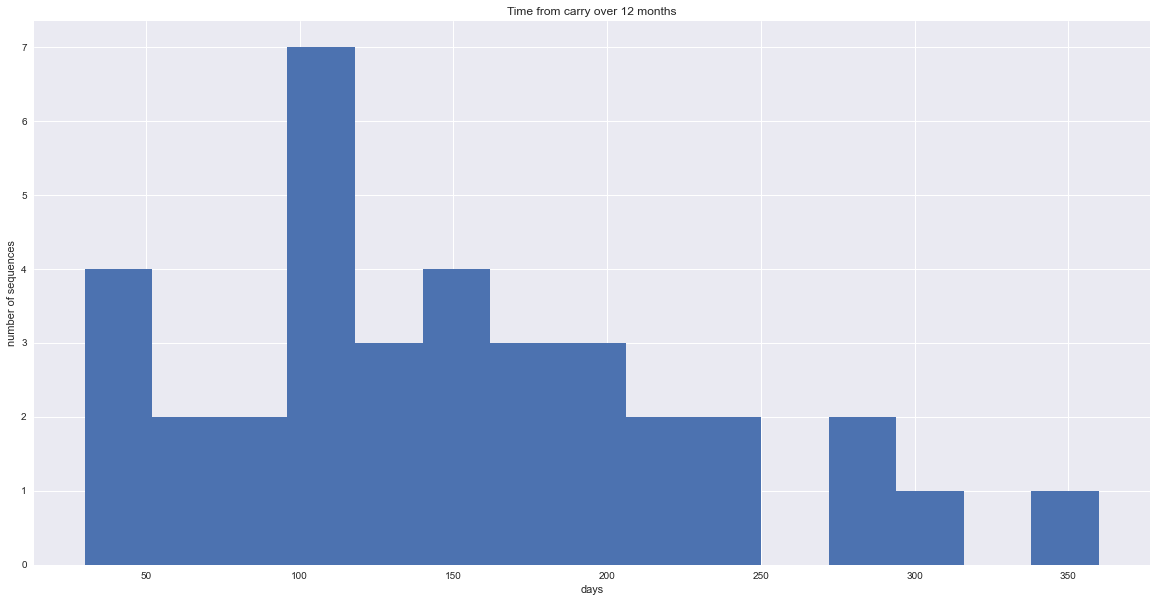

In [21]:
plt.figure(figsize=(20,10))
month_12_carry_over = data_pd.loc[data_pd.insertion_type_12 == "carry_over"]
plt.hist(month_12_carry_over.time_range_12, bins = 15)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from carry over 12 months")


### interpolation over time distribution

Text(0.5, 1.0, 'Time from interpolation 6 months')

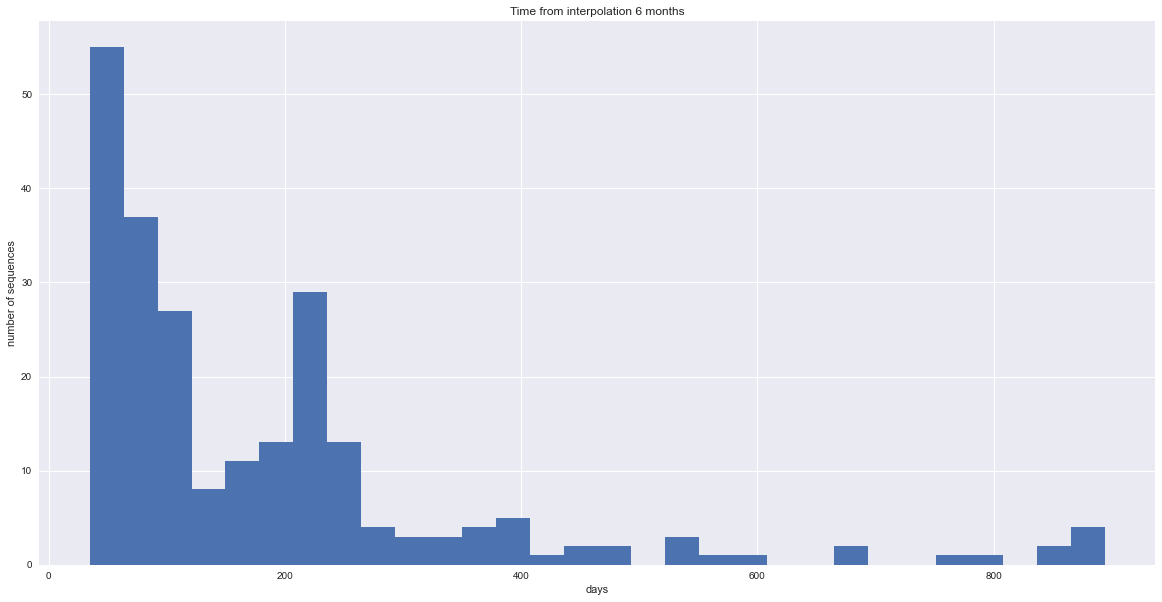

In [22]:
plt.figure(figsize=(20,10))
month_6_interpolation = data_pd.loc[data_pd.insertion_type_6 == "interpolation"]
plt.hist(month_6_interpolation.time_range_6, bins = 30)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from interpolation 6 months")

Text(0.5, 1.0, 'Time from interpolation 12 months')

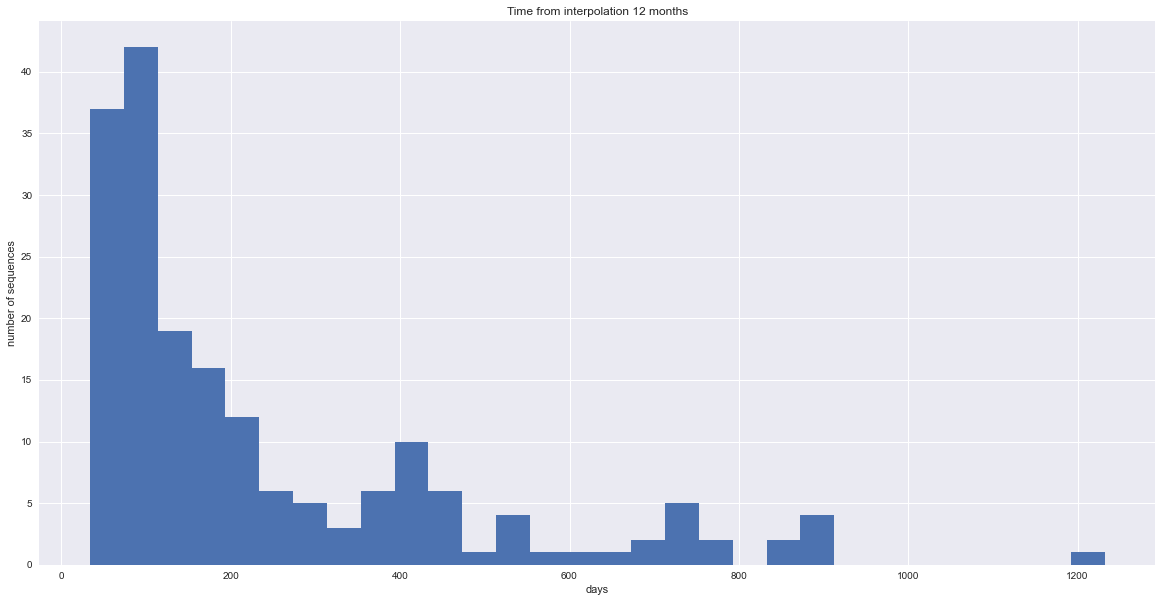

In [23]:
plt.figure(figsize=(20,10))
month_12_interpolation = data_pd.loc[data_pd.insertion_type_12 == "interpolation"]
plt.hist(month_12_interpolation.time_range_12, bins = 30)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from interpolation 12 months")

#### Time until dry

In [24]:
start_dry = data_pd.total_fluid_1 == 0

print(f"Number of sequences starting as dry: ", sum(start_dry))

# exclude dry start sequences
fluid_pd = data_pd.loc[~start_dry]

print(f"Number of sequences dry after 3 months: ", sum(fluid_pd.total_fluid_3 == 0))
print(f"Number of sequences dry after 6 months: ", sum(fluid_pd.total_fluid_6 == 0))
print(f"Number of sequences dry after 12 months: ", sum(fluid_pd.total_fluid_12 == 0))
print(f"Number of sequences dry after 24 months: ", sum(fluid_pd.total_fluid_24 == 0))

Number of sequences starting as dry:  13
Number of sequences dry after 3 months:  17
Number of sequences dry after 6 months:  11
Number of sequences dry after 12 months:  17
Number of sequences dry after 24 months:  17


## Filter data based on time series eclusion criterias

In [25]:
columns = ["time_range_3", "time_range_before_3", "time_range_after_3", "insertion_type_3",
            "time_range_6", "time_range_before_6", "time_range_after_6", "insertion_type_6", 
           "time_range_12", "time_range_before_12", "time_range_after_12", "insertion_type_12"]

filter_base = data_pd[columns]

# filter for fist month where VA values are available
filter_1 = ~data_pd.cur_va_rounded_1.isna()

# 3 month bools
interp_3 = filter_base.insertion_type_3 == "interpolation" 
carry_over_3 = filter_base.insertion_type_3 == "carry_over" 
match_3 = filter_base.insertion_type_3 == "match" 

# 6 month bools
interp_6 = filter_base.insertion_type_6 == "interpolation" 
carry_over_6 = filter_base.insertion_type_6 == "carry_over" 
match_6 = filter_base.insertion_type_6 == "match" 

# 12 month bools
interp_12 = filter_base.insertion_type_12 == "interpolation" 
carry_over_12 = filter_base.insertion_type_12 == "carry_over" 
match_12 = filter_base.insertion_type_12 == "match"

DAY_FILTER = 60

# interpolation time filters
interp_time_before_3 = filter_base.time_range_before_3 < DAY_FILTER
interp_time_after_3 = filter_base.time_range_after_3 < DAY_FILTER

interp_time_before_6 = filter_base.time_range_before_6 < DAY_FILTER
interp_time_after_6 = filter_base.time_range_after_6 < DAY_FILTER

interp_time_before_12 = filter_base.time_range_before_12 < DAY_FILTER
interp_time_after_12 = filter_base.time_range_after_12 < DAY_FILTER

# carry over time filters
carry_over_time_after_3 = filter_base.time_range_3 < DAY_FILTER
carry_over_time_after_6 = filter_base.time_range_6 < DAY_FILTER
carry_over_time_after_12 = filter_base.time_range_12 < DAY_FILTER

In [26]:
# interpolation 3 months
interp_bef = np.logical_and(interp_3.values, interp_time_before_3)
interp_aft = np.logical_and(interp_3.values, interp_time_after_3)

interp_3 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_3 = np.logical_and(carry_over_3.values, carry_over_time_after_3)

insertion_3_ = np.logical_or(carry_over_3, interp_3)
filter_3 = np.logical_or(insertion_3_, match_3)

print("Number of filtered sequences for 3 months are:", sum(filter_3))


# interpolation 6 months
interp_bef = np.logical_and(interp_6.values, interp_time_before_6)
interp_aft = np.logical_and(interp_6.values, interp_time_after_6)

interp_6 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_6 = np.logical_and(carry_over_6.values, carry_over_time_after_6)

insertion_6_ = np.logical_or(carry_over_6, interp_6)
filter_6 = np.logical_or(insertion_6_, match_6)

print("Number of filtered sequences for 6 months are:", sum(filter_6))


# interpolation 12 months
interp_bef = np.logical_and(interp_12.values, interp_time_before_12)
interp_aft = np.logical_and(interp_12.values, interp_time_after_12)

interp_12 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_12 = np.logical_and(carry_over_12.values, carry_over_time_after_12)

insertion_12_ = np.logical_or(carry_over_12, interp_12)
filter_12 = np.logical_or(insertion_12_, match_12)

print("Number of filtered sequences for 12 months are:", sum(filter_12))

Number of filtered sequences for 3 months are: 234
Number of filtered sequences for 6 months are: 265
Number of filtered sequences for 12 months are: 254


## Filter statistics

In [27]:
print("", np.sum(filter_1))
print("", np.sum(filter_1&filter_3&filter_6&filter_12))
print("", np.sum(filter_1&filter_6&filter_12))
print("", np.sum(filter_1&filter_12))
print("", np.sum(filter_1&filter_6))
print("", np.sum(filter_1&filter_3))
print("", np.sum(filter_1&filter_3&filter_6))
print("", np.sum(filter_1&filter_3&filter_12))

 395
 131
 175
 243
 254
 225
 185
 156


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

PIXEL_TO_VOLUME = 0.010661*0.003872*0.112878

In [29]:
def sum_etdrs(table, time):
    label_mapping = {f"_1_{time}":f"epm_{time}", f"_3_{time}":f"irf_{time}", f"_4_{time}":f"srf_{time}", 
                     f"_5_{time}":f"srhm_{time}", f"_6_{time}":f"rpe_{time}", f"_7_{time}":f"fvpde_{time}", 
                     f"_8_{time}":f"drusen_{time}", f"_9_{time}":f"phm_{time}", f"_10_{time}":f"choroid_{time}", 
                     f"_13_{time}":f"fibrosis_{time}"}
    
    feature_names = [f"_1_{time}", f"_3_{time}", 
                     f"_4_{time}", f"_5_{time}", 
                     f"_6_{time}", f"_7_{time}", 
                     f"_8_{time}", f"_9_{time}", 
                     f"_10_{time}", f"_13_{time}"]


    table_non_spatial_pd = pd.DataFrame([])

    for feature in feature_names:
        col_to_sum = table.columns.str.endswith(feature)
        table_non_spatial_pd[feature] = table.iloc[:,col_to_sum].sum(1)

    table_non_spatial_pd = table_non_spatial_pd.rename(columns=label_mapping)
    return table_non_spatial_pd*PIXEL_TO_VOLUME

def get_feature_dicts(times, table):
    feature_dict = {}
    for time in times:
            feature_dict[f"feature_{time}"] = sum_etdrs(table, time=time)
    
    delta_feature_dict = {}
    
    # calculate delta columns
    for k, time in enumerate(times):
        if k < len(times) - 1:
            remaining_tps = times[k + 1:]
            for next_time_point in remaining_tps:
                delta_columns = []
                for col in feature_dict[f"feature_{time}"].columns:
                    feat, t = col.split("_")
                    delta_columns.append(f"{feat}_{next_time_point}_delta_{t}")
                    
                delta_pd = pd.DataFrame(np.array(feature_dict[f"feature_{next_time_point}"]) - 
                                        np.array(feature_dict[f"feature_{time}"]),
                                       columns=delta_columns)

                delta_feature_dict[f"feature_{next_time_point}_{time}"] = delta_pd
    return {**delta_feature_dict, **feature_dict}

def get_va_dict(times, table):
    column_starter = "cur_va_rounded_"
    va_dict = {}
    delta_va_dict = {}
    
    for time in times:
        va_dict[f"va_{time}"] = table[f"cur_va_rounded_{time}"]
        
    # calculate delta columns
    for k, time in enumerate(times):
        if k < len(times) - 1:
            remaining_tps = times[k + 1:]
            for next_time_point in remaining_tps:
                delta_columns = [f"va_{next_time_point}_delta_{time}"]
                
                delta_pd = pd.DataFrame(np.array(va_dict[f"va_{next_time_point}"]) - np.array(va_dict[f"va_{time}"]),
                                       columns=delta_columns)
                delta_va_dict[f"va_{next_time_point}_{time}"] = delta_pd
    
    return {**delta_va_dict, **va_dict}


time_filters = {1: filter_1, 3: filter_3, 6: filter_6, 12: filter_12}

def associate_time_n_factors(table=None, spatial_sum=False, times=[1, 12]):
    # filter time points
    for tp in times:
        table = table[time_filters[tp]]
    
    seq_columns = ['patient_id', 'laterality']
    table["seq"] = table[seq_columns[0]] + "_" + table[seq_columns[1]]
    
    # sum etdrs features for seg features across the time points    
    features_data_dict = get_feature_dicts(times, table)
    va_data_dict = get_va_dict(times, table)
    
    data_dict = {**va_data_dict, **features_data_dict} 
    data_frames = list(data_dict.keys())

    df = data_dict[data_frames[0]]
    for data_frame in data_frames[1:]:
        df = pd.concat([df.reset_index(drop=True), data_dict[data_frame].reset_index(drop=True)], axis=1)
    
    for time in times[1:]:
        df[f"n_injections_{time}"] = table[f"cumsum_injections_{time}"].values.tolist()
    # filter all columns for the independent ones in list
    df.index = table["seq"]
    return df

In [30]:
def assert_times(time_point_list):
    allowed_values = [1, 3, 6, 12]
    
    for value in time_point_list:
        if value not in allowed_values:
            return False
        else:
            continue
    return True

# features dependents
def get_seg_dependents_str(seg_features, seg_delta, seg_times):
    seg_dependents = []

    for seg_feature in seg_features:
        for time in seg_times:
            seg_dependents.append(f"{seg_feature}_{time}") 
    
        if seg_delta:
            # add all delta columns
            for k, s_time in enumerate(seg_times[:-1]):

                remaining_times = deepcopy(seg_times)
                remaining_times.remove(s_time)

                for r_time in remaining_times[k:]:
                    if f"{r_time}-{s_time}" in seg_delta:
                        seg_dependents.append(f"{seg_feature}_{r_time}_delta_{s_time}")

    return seg_dependents

def get_va_dependents_str(va_delta, va_times):
    va_dependents = []

    for va_time in va_times:
        va_dependents.append(f"cur_va_rounded_{va_time}")
    
    if va_delta:
        # add all delta columns
        for k, s_time in enumerate(va_times[:-1]):

            remaining_times = deepcopy(va_times)
            remaining_times.remove(s_time)

            for r_time in remaining_times[k:]:
                if f"{r_time}-{s_time}" in va_delta:
                    va_dependents.append(f"va_{r_time}_delta_{s_time}")
                else:
                    continue
    return va_dependents

### Factors associated with baseline VA

In [126]:
data_pd

,Unnamed: 0,sequence,study_date_1,total_fluid_1,time_range_1,time_range_before_1,time_range_after_1,insertion_type_1,cur_va_rounded_1,next_va_1,...,T2_13_24,S1_13_24,S2_13_24,N1_13_24,N2_13_24,C0_13_24,I1_13_24,I2_13_24,patient_id,laterality
0,0,18_R,2017-09-26,569.0,NaN,NaN,NaN,NaN,0.40,0.397940,...,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,18,R
1,1,502_R,2016-04-04,0.0,NaN,NaN,NaN,NaN,0.10,0.494850,...,0.0,2.47619,0.0,21.619048,0.0,46.142857,0.0,0.0,502,R
2,2,709_L,2016-08-08,20367.0,NaN,NaN,NaN,NaN,0.30,0.397940,...,0.0,4206.00000,0.0,14946.000000,396.0,13862.000000,0.0,0.0,709,L
3,3,709_R,2015-11-25,2233.0,NaN,NaN,NaN,NaN,0.89,1.000000,...,56169.0,0.00000,0.0,0.000000,2.0,0.000000,9357.0,31865.0,709,R
4,4,1263_L,2015-07-28,3198.0,NaN,NaN,NaN,NaN,0.40,0.397940,...,0.0,3.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,1263,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,419,359944_L,2017-10-11,21782.0,NaN,NaN,NaN,NaN,1.00,0.397940,...,79.0,6817.00000,84.0,739.000000,0.0,394.000000,0.0,0.0,359944,L
420,420,359944_R,2017-10-11,0.0,NaN,NaN,NaN,NaN,0.40,0.200659,...,0.0,0.00000,0.0,0.000000,237.0,0.000000,0.0,0.0,359944,R
421,421,363725_R,2018-02-08,8900.0,NaN,NaN,NaN,NaN,0.40,0.494850,...,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,363725,R
422,422,365435_L,2018-03-05,141567.0,NaN,NaN,NaN,NaN,2.30,0.397940,...,9298.0,0.00000,0.0,20724.000000,13007.0,9078.000000,24998.0,2344.0,365435,L


In [31]:
'''
Available features: epm, irf, srf, srhm, rpe, fv_pde, drusen, phm, choroid, fibrosis
'''
from copy import deepcopy

'''
exmaples feature setting: 

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1", "6-3"]
seg_times = [1, 3, 6, 12]

va_delta = ["3-1", "6-3"]
va_times = [1, 3, 6]

injection_times = [3, 6]
'''

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = []
seg_times = [1]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_dependents_str(seg_features, seg_delta, seg_times)

va_delta = []
va_times = []

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = []

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_dependents.append(f"n_injections_{it}")

abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1])

independent_variables = injection_independents + seg_independents + va_independents
    
# set independent vars
df_regression = abt[independent_variables]

# set dependent var
df_regression["y"] = abt["cur_va_rounded_1"]

#### fit model

In [32]:

model_lin = sm.OLS.from_formula(f"y ~ {' + '.join(independent_variables)}", 
                                data=df_regression)

result_lin = model_lin.fit()
regression_summary = result_lin.summary()
reg_table = pd.read_html(result_lin.summary().tables[1].as_html(),header=0,index_col=0)[0]

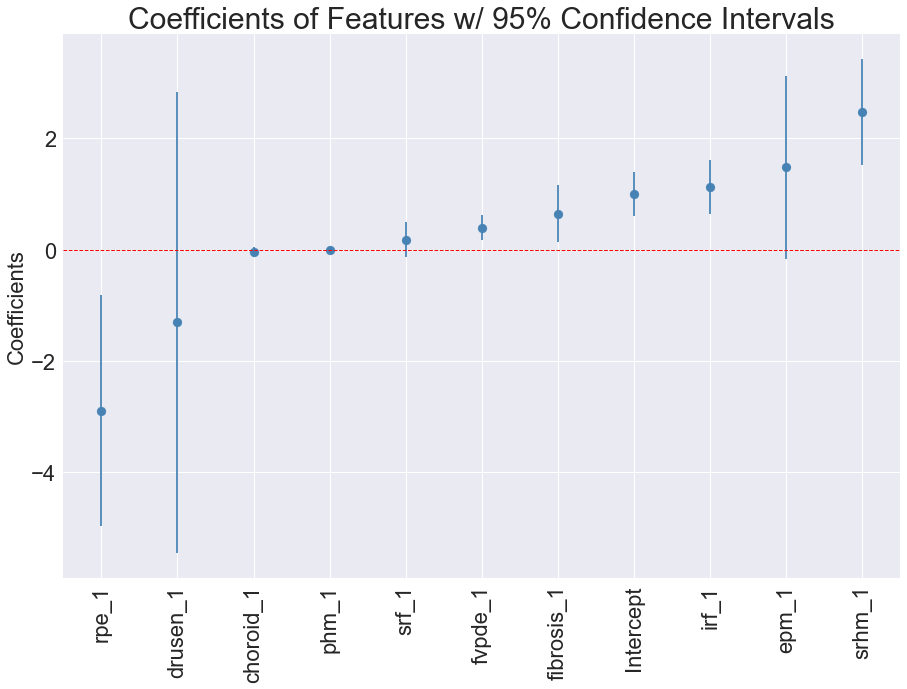

In [33]:
# Plot coefficients w/95% confidence intervals for Model
coefplot(result_lin)

In [34]:
from statsmodels.tools.eval_measures import meanabs

X = df_regression[independent_variables]
y = df_regression["y"]

# now generate predictions
ypred = result_lin.predict(X)

# calc rmse
mae = meanabs(y, ypred)
mae_mean_predictor = meanabs(y, [y.mean()]*y.shape[0])

print("model mae is: ", mae, "mean predictor mae is: ", mae_mean_predictor)

model mae is:  0.25328631194831486 mean predictor mae is:  0.31606383592373016


In [35]:
regression_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     22.34
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           1.63e-30
Time:                        16:37:14   Log-Likelihood:                -129.69
No. Observations:                 395   AIC:                             279.4
Df Residuals:                     385   BIC:                             319.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0071      0.201      5.015      0.000       0.612       1.402
epm_1          1.4809      0.836      1.771      0.077      -0.163       3.125
irf_1          1.1220      0.248      4.517      0.000       0.634       1.610
srf_1          0.1793      0.161      1.110      0.267      -0.138       0.497
srhm_1         2.4772      0.484      5.119      0.000       1.526       3.429
rpe_1         -2.8965      1.056     -2.744      0.006      -4.972      -0.821
fvpde_1        0.3943      0.114      3.464      0.001       0.171       0.618
drusen_1      -1.3092      2.109     -0.621      0.535      -5.456       2.838
phm_1      -2.307e-16   2.41e-16     -0.956      0.339   -7.05e-16    2.44e-16
choroid_1     -0.0431      0.044     -0.986      0.325      -0.129       0.043
fibrosis_1     0.6440      0.262      2.461      0.014       0.130       1.158
==============================================================================
Omnibus:                       53.836   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.216
Skew:                           0.881   Prob(JB):                     3.81e-18
Kurtosis:                       4.330   Cond. No.                     2.55e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.16e-36. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## One year Baseline Adata

In [36]:
'''
Available features: epm, irf, srf, srhm, rpe, fv_pde, drusen, phm, choroid, fibrosis
'''
from copy import deepcopy

'''
exmaples feature setting: 

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1", "6-3"]
seg_times = [1, 3, 6, 12]

va_delta = ["3-1", "6-3"]
va_times = [1, 3, 6]

injection_times = [3, 6]
'''

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["12-1"]
seg_times = [1, 12]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_dependents_str(seg_features, seg_delta, seg_times)

va_delta = []
va_times = []

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = [12]

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_independents.append(f"n_injections_{it}")

# extract abt table for regression, automativcally filters for all sequences with available data
abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1, 12])

independent_variables = injection_independents + seg_independents + va_independents

columns_to_exclude = [
                      # "epm_12", "irf_12", "srf_12", "srhm_12", "rpe_12", 
                      #"fvpde_12", "drusen_12", "phm_12", "choroid_12", 
                      #"fibrosis_12"
]

for col_to_remove in columns_to_exclude:
    independent_variables.remove(col_to_remove)
    
# set independent vars
df_regression = abt[independent_variables]

# set dependent var
df_regression["y"] = abt["cur_va_rounded_12"]

#### Fit linear model

In [37]:
model_lin = sm.OLS.from_formula(f"y ~ {' + '.join(independent_variables)}", 
                                data=df_regression)

result_lin = model_lin.fit()

regression_summary = result_lin.summary()

reg_table = pd.read_html(result_lin.summary().tables[1].as_html(),header=0,index_col=0)[0]

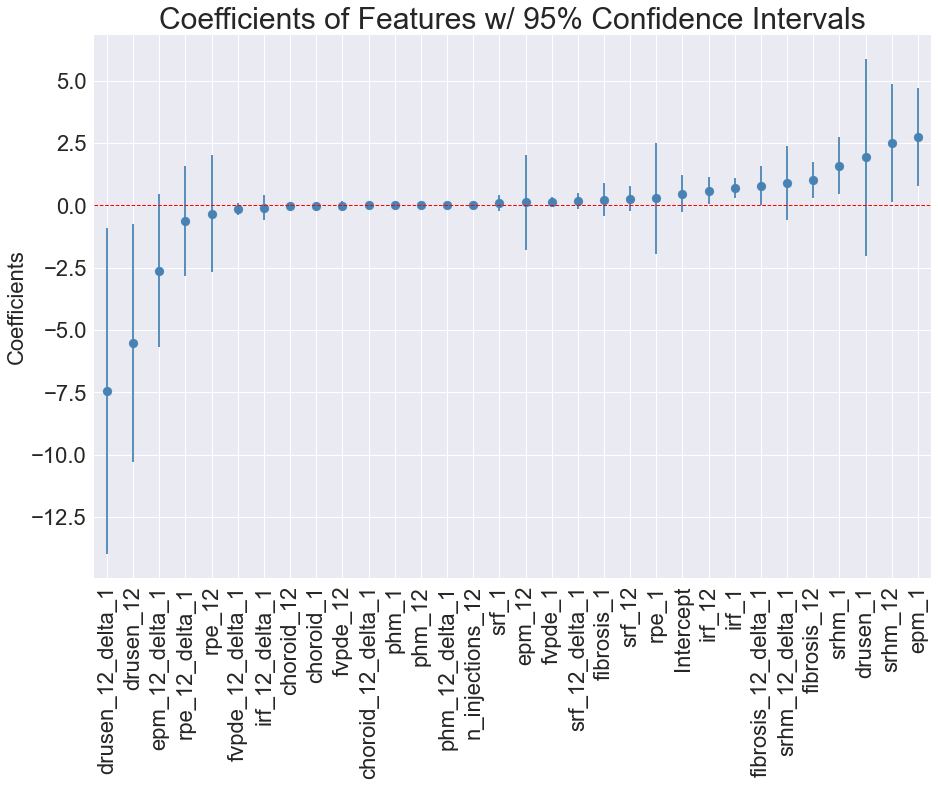

In [38]:
# Plot coefficients w/95% confidence intervals for Model
coefplot(result_lin)

In [39]:
regression_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     7.761
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           3.57e-16
Time:                        16:37:15   Log-Likelihood:                -71.468
No. Observations:                 243   AIC:                             182.9
Df Residuals:                     223   BIC:                             252.8
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4615      0.377      1.226      0.222      -0.280       1.204
n_injections_12       1.93e-05      0.007      0.003      0.998      -0.013       0.013
epm_1                   2.7374      1.001      2.735      0.007       0.765       4.710
epm_12                  0.1184      0.965      0.123      0.902      -1.783       2.020
epm_12_delta_1         -2.6190      1.551     -1.689      0.093      -5.675       0.437
irf_1                   0.6852      0.203      3.370      0.001       0.285       1.086
irf_12                  0.5854      0.277      2.115      0.036       0.040       1.131
irf_12_delta_1         -0.0998      0.257     -0.389      0.698      -0.606       0.406
srf_1                   0.0875      0.159      0.549      0.583      -0.226       0.401
srf_12                  0.2597      0.252      1.030      0.304      -0.237       0.757
srf_12_delta_1          0.1723      0.171      1.006      0.316      -0.165       0.510
srhm_1                  1.5960      0.583      2.738      0.007       0.447       2.745
srhm_12                 2.4975      1.198      2.084      0.038       0.136       4.859
srhm_12_delta_1         0.9015      0.748      1.205      0.229      -0.573       2.376
rpe_1                   0.2817      1.131      0.249      0.803      -1.947       2.510
rpe_12                 -0.3436      1.189     -0.289      0.773      -2.687       2.000
rpe_12_delta_1         -0.6253      1.116     -0.560      0.576      -2.826       1.575
fvpde_1                 0.1401      0.099      1.414      0.159      -0.055       0.335
fvpde_12               -0.0121      0.102     -0.119      0.905      -0.213       0.188
fvpde_12_delta_1       -0.1522      0.126     -1.207      0.229      -0.401       0.096
drusen_1                1.9179      1.997      0.961      0.338      -2.017       5.853
drusen_12              -5.5169      2.425     -2.275      0.024     -10.295      -0.739
drusen_12_delta_1      -7.4348      3.318     -2.241      0.026     -13.973      -0.896
phm_1                        0          0        nan        nan           0           0
phm_12                       0          0        nan        nan           0           0
phm_12_delta_1               0          0        nan        nan           0           0
choroid_1              -0.0382      0.038     -1.018      0.310      -0.112       0.036
choroid_12             -0.0419      0.039     -1.073      0.284      -0.119       0.035
choroid_12_delta_1     -0.0037      0.047     -0.079      0.937      -0.096       0.088
fibrosis_1              0.2219      0.340      0.653      0.515      -0.448       0.892
fibrosis_12             1.0039      0.369      2.722      0.007       0.277       1.731
fibrosis_12_delta_1     0.7820      0.400      1.954      0.052      -0.007       1.571
===

In [40]:
from statsmodels.tools.eval_measures import meanabs

X = df_regression[independent_variables]
y = df_regression["y"]

# now generate predictions
ypred = result_lin.predict(X)

# calc rmse
mae = meanabs(y, ypred)

mae_mean_predictor = meanabs(y, [y.mean()]*y.shape[0])

print("model mae is: ", mae, "mean predictor mae is: ", mae_mean_predictor)

model mae is:  0.2543441929913522 mean predictor mae is:  0.31794366452822415


# Which features explain 12 month VA

In [90]:
'''
Available features: epm, irf, srf, srhm, rpe, fv_pde, drusen, phm, choroid, fibrosis
'''
from copy import deepcopy

'''
exmaples feature setting: 

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1", "6-3"]
seg_times = [1, 3, 6, 12]

va_delta = ["3-1", "6-3"]
va_times = [1, 3, 6]

injection_times = [3, 6]
'''

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1"]
seg_times = [1, 3, 12]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_dependents_str(seg_features, seg_delta, seg_times)

va_delta = ["3-1"]
va_times = [1, 3, 12]

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = [3, 12]

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_independents.append(f"n_injections_{it}")

# extract abt table for regression, automativcally filters for all sequences with available data
abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1, 3, 12])

independent_variables = injection_independents + seg_independents + va_independents

columns_to_exclude = ["epm_12", "irf_12", "srf_12", "srhm_12", "rpe_12", 
                      "fvpde_12", "drusen_12", "phm_12", "choroid_12", 
                      "fibrosis_12", 
                      
                      #"epm_6", "irf_6", "srf_6", "srhm_6", "rpe_6", 
                      #"fvpde_6", "drusen_6", "phm_6", "choroid_6", "fibrosis_6",
                      
                      #"epm_3", "irf_3", "srf_3", "srhm_3", "rpe_3", 
                      #"fvpde_3", "drusen_3", "phm_3", "choroid_3", "fibrosis_3",
                      
                      #"cur_va_rounded_3", 
                      #"cur_va_rounded_6", 
                      "cur_va_rounded_12",
                      
                      #"n_injections_3", 
                      #"n_injections_6",
                      #"n_injections_12"
                     
                     ]

'''
abt["regular_treatment"] = abt.n_injections_3 >= 3

abt["va_3month_improvement"] = None

strong_f = abt["va_3_delta_1"] <= -0.2
weak_f = (abt["va_3_delta_1"] <= 0) & (abt["va_3_delta_1"] > -0.2)
no_f =  abt["va_3_delta_1"] > 0

abt["va_3month_improvement"][strong_f] = 2
abt["va_3month_improvement"][weak_f] = 1
abt["va_3month_improvement"][no_f] = 0

abt["va_3month_improvement"] = abt["va_3month_improvement"].astype(int)
'''
independent_variables = independent_variables #+ ["regular_treatment", "va_3month_improvement"]

for col_to_remove in columns_to_exclude:
    if col_to_remove in independent_variables:
        independent_variables.remove(col_to_remove)
    
# set independent vars
df_regression = abt[independent_variables]

# set dependent var
df_regression["y"] = abt["cur_va_rounded_12"] - abt["cur_va_rounded_1"]


model_lin = sm.OLS.from_formula(f"y ~ {' + '.join(independent_variables)}", 
                                data=df_regression)

result_lin = model_lin.fit()

regression_summary = result_lin.summary()

reg_table = pd.read_html(result_lin.summary().tables[1].as_html(),header=0,index_col=0)[0]


from statsmodels.tools.eval_measures import meanabs

X = df_regression[independent_variables]
y = df_regression["y"]

# now generate predictions
ypred = result_lin.predict(X)

# calc rmse
mae = meanabs(y, ypred)
mae_mean_predictor = meanabs(y, [df_regression.cur_va_rounded_1.mean()]*y.shape[0])

print("model mae is: ", mae, "mean predictor mae is: ", mae_mean_predictor)

regression_summary

model mae is:  0.13876969458983815 mean predictor mae is:  0.6679094465046671


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     9.176
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           1.54e-17
Time:                        17:03:33   Log-Likelihood:                 32.188
No. Observations:                 156   AIC:                            -18.38
Df Residuals:                     133   BIC:                             51.77
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.5828      0.388     -1.503      0.135      -1.350       0.184
n_injections_3         0.0121      0.010      1.154      0.251      -0.009       0.033
n_injections_12       -0.0116      0.008     -1.524      0.130      -0.027       0.003
epm_1                  3.8013      1.189      3.197      0.002       1.450       6.153
epm_3                 -2.1743      1.233     -1.763      0.080      -4.613       0.265
epm_3_delta_1         -5.9756      2.218     -2.694      0.008     -10.363      -1.588
irf_1                 -0.0189      0.200     -0.094      0.925      -0.415       0.377
irf_3                  0.1885      0.253      0.747      0.457      -0.311       0.688
irf_3_delta_1          0.2074      0.190      1.089      0.278      -0.169       0.584
srf_1                 -0.3585      0.301     -1.193      0.235      -0.953       0.236
srf_3                 -0.3902      0.591     -0.660      0.510      -1.560       0.779
srf_3_delta_1         -0.0317      0.316     -0.100      0.920      -0.656       0.593
srhm_1                 0.1960      0.551      0.356      0.723      -0.894       1.286
srhm_3                 1.7365      1.267      1.371      0.173      -0.769       4.242
srhm_3_delta_1         1.5405      0.794      1.939      0.055      -0.031       3.112
rpe_1                  2.1932      1.044      2.100      0.038       0.128       4.259
rpe_3                  1.6005      1.338      1.196      0.234      -1.046       4.247
rpe_3_delta_1         -0.5927      1.199     -0.494      0.622      -2.964       1.779
fvpde_1               -0.0120      0.089     -0.135      0.893      -0.187       0.163
fvpde_3               -0.1237      0.106     -1.161      0.248      -0.334       0.087
fvpde_3_delta_1       -0.1117      0.120     -0.932      0.353      -0.349       0.125
drusen_1              -0.4023      1.867     -0.215      0.830      -4.096       3.292
drusen_3               0.1709      2.107      0.081      0.935      -3.997       4.339
drusen_3_delta_1       0.5732      3.390      0.169      0.866      -6.133       7.279
phm_1                       0          0        nan        nan           0           0
phm_3                       0          0        nan        nan           0           0
phm_3_delta_1               0          0        nan        nan           0           0
choroid_1             -0.0405      0.030     -1.331      0.186      -0.101       0.020
choroid_3             -0.0269      0.031     -0.869      0.387      -0.088       0.034
choroid_3_delta_1      0.0136      0.036      0.374      0.709      -0.058       0.085
fibrosis_1             0.5065      0.295      1.716      0.088      -0.077       1.090
fibrosis_3             0.6540      0.389      1.679      0.095      -0.116       1.424
fibrosis_3_delta_1     0.1475      0.3

In [125]:
df_regression

,n_injections_3,n_injections_12,epm_1,epm_3,epm_3_delta_1,irf_1,irf_3,irf_3_delta_1,srf_1,srf_3,...,choroid_1,choroid_3,choroid_3_delta_1,fibrosis_1,fibrosis_3,fibrosis_3_delta_1,cur_va_rounded_1,cur_va_rounded_3,va_3_delta_1,y
seq,,,,,,,,,,,,,,,,,,,,,
18_R,5.000000,11.0,0.000177,0.000718,0.000541,0.002572,0.003658,0.001086,0.000079,0.000033,...,1.280016,1.311179,0.031163,0.000000,0.000000,0.000000,0.4,0.2,-0.2,-0.1
709_L,3.000000,8.0,0.046623,0.039681,-0.006943,0.008564,0.000144,-0.008420,0.086337,0.000000,...,0.887427,0.723267,-0.164160,0.004534,0.006891,0.002358,0.3,0.6,0.3,0.3
1475_L,3.000000,6.0,0.000979,0.002018,0.001039,0.029961,0.000000,-0.029961,0.000172,0.000019,...,0.727195,0.636996,-0.090199,0.000000,0.000028,0.000028,0.6,0.6,0.0,0.0
1475_R,2.000000,9.0,0.026438,0.035948,0.009510,0.083103,0.128268,0.045165,0.075251,0.013601,...,0.677068,0.868221,0.191153,0.075536,0.111997,0.036461,1.0,1.1,0.1,0.0
2005_L,4.000000,13.0,0.002749,0.000783,-0.001966,0.000163,0.000037,-0.000126,0.021425,0.043548,...,1.277426,1.335917,0.058491,0.000000,0.000000,0.000000,0.4,0.6,0.2,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357432_L,3.000000,8.0,0.019123,0.013666,-0.005456,0.000266,0.000019,-0.000247,0.003718,0.002097,...,1.169287,1.461547,0.292260,0.001510,0.000000,-0.001510,0.0,0.3,0.3,0.2
357432_R,4.000000,10.0,0.001058,0.001808,0.000750,0.000168,0.000070,-0.000098,0.000219,0.000000,...,1.174254,0.718691,-0.455563,0.000000,0.000000,0.000000,0.3,0.0,-0.3,-0.2
358833_R,3.000000,9.0,0.005219,0.002889,-0.002330,0.000023,0.000000,-0.000023,0.029276,0.000461,...,0.897021,0.839709,-0.057312,0.000000,0.000000,0.000000,0.8,0.3,-0.5,-0.4


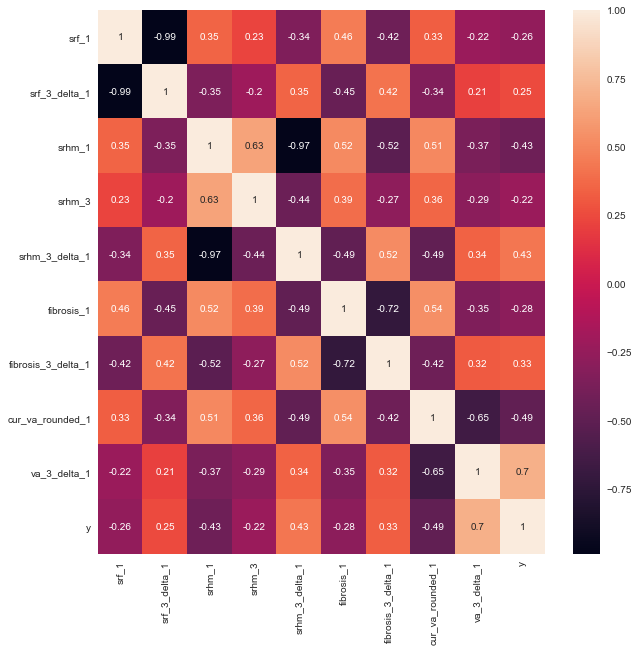

In [91]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

df = df_regression

corrMatrix = df.corr()

# filter corr table
corr_filter = np.abs(corrMatrix.loc["y",:]) > 0.2

filtered_columns = filtered_columns = corrMatrix.columns[corr_filter.values].tolist()

corrMatrix_filtered = corrMatrix.loc[corr_filter.values, corr_filter.values]

sn.heatmap(corrMatrix_filtered, annot=True)
plt.show()

0it [00:00, ?it/s]

Number of cvs set to number of patients:  10
cur_va_rounded_3 not in list
cur_va_rounded_6 not in list


10it [00:07,  1.29it/s]

Model R2 over 10 cross val runs is: 0.350032806602564


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'srf_1'),
  Text(1, 0, 'srf_3_delta_1'),
  Text(2, 0, 'srhm_1'),
  Text(3, 0, 'srhm_3'),
  Text(4, 0, 'srhm_3_delta_1'),
  Text(5, 0, 'fibrosis_1'),
  Text(6, 0, 'fibrosis_3_delta_1'),
  Text(7, 0, 'cur_va_rounded_1'),
  Text(8, 0, 'va_3_delta_1')])

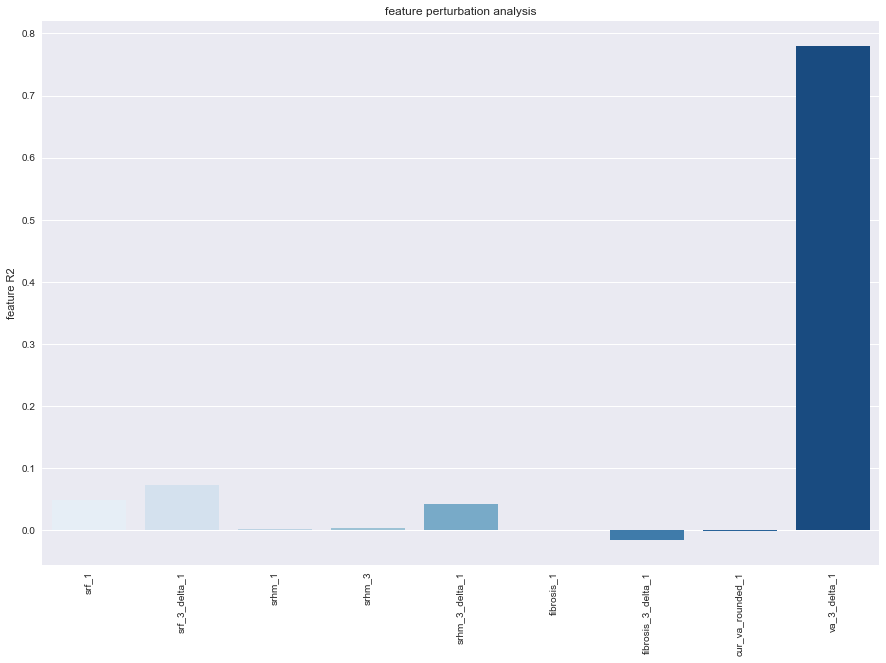

In [92]:
## Permutation test
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GroupShuffleSplit
from tqdm import tqdm

N_CROSS_VALIDATIONS =  10 #np.unique(np.array(patient_ids)).shape[0]

print("Number of cvs set to number of patients: ", N_CROSS_VALIDATIONS)

patient_ids = [id_.replace("_R", "").replace("_L", "") for id_ in df_regression.index.tolist()]

df_regression_model = df_regression.reset_index()

try:
    filtered_columns.remove("y")
except:
    print("y not in list")
    
try:
    filtered_columns.remove('cur_va_rounded_3')
except:
    print("cur_va_rounded_3 not in list")
    
try:
    filtered_columns.remove('cur_va_rounded_6')
except:
    print("cur_va_rounded_6 not in list")

'''
try:
    filtered_columns.remove('va_6_delta_1')
except:
    print("va_6_delta_1 not in list")
    
'''

X = df_regression_model[filtered_columns]
y = df_regression_model["y"]

gss = GroupShuffleSplit(n_splits=N_CROSS_VALIDATIONS, train_size=.7)
gss.get_n_splits()

gss.get_n_splits()

importance_scores = np.zeros(len(filtered_columns))
model_r2 = 0

for train_ids, test_ids in tqdm(gss.split(X, y, patient_ids)):
    X_train = X.loc[train_ids,:]
    X_val = X.loc[test_ids,:]

    y_train = y[train_ids]
    y_val = y[test_ids] 

    model = Ridge(alpha=1e-2).fit(X_train, y_train)
    model_r2 += model.score(X_val, y_val)

    from sklearn.inspection import permutation_importance
    r = permutation_importance(model, X_val, y_val,
                               n_repeats=30)
    
    importance_scores += r.importances_mean

# average importance scores over runs
importance_scores /= N_CROSS_VALIDATIONS

print(f"Model R2 over {N_CROSS_VALIDATIONS} cross val runs is: {model_r2 / N_CROSS_VALIDATIONS}")

x = filtered_columns
y = importance_scores

#### feature importance plot
plt.figure(figsize=(15, 10))
sns.barplot(x, y, palette="Blues")
plt.ylabel("feature R2")
plt.title("feature perturbation analysis")
plt.xticks(rotation=90)

# Factors associated with Fibrosis progression

In [27]:
'''
Available features: epm, irf, srf, srhm, rpe, fv_pde, drusen, phm, choroid, fibrosis
'''
from copy import deepcopy

'''
exmaples feature setting: 

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1", "6-3"]
seg_times = [1, 3, 6, 12]

va_delta = ["3-1", "6-3"]
va_times = [1, 3, 6]

injection_times = [3, 6]
'''

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["12-1"]
seg_times = [1, 12]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_dependents_str(seg_features, seg_delta, seg_times)

va_delta = []
va_times = []

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = [12]

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_independents.append(f"n_injections_{it}")

# extract abt table for regression, automativcally filters for all sequences with available data
abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1, 12])

independent_variables = injection_independents + seg_independents + va_independents

columns_to_exclude = ["epm_12", "irf_12", "srf_12", "srhm_12", "rpe_12", 
                      "fvpde_12", "drusen_12", "phm_12", "choroid_12", 
                      "fibrosis_12", "fibrosis_12_delta_1"]

for col_to_remove in columns_to_exclude:
    independent_variables.remove(col_to_remove)
    
# set independent vars
df_regression = abt[independent_variables]

# set dependent var
df_regression["y"] = abt["fibrosis_12"] - abt["fibrosis_1"]

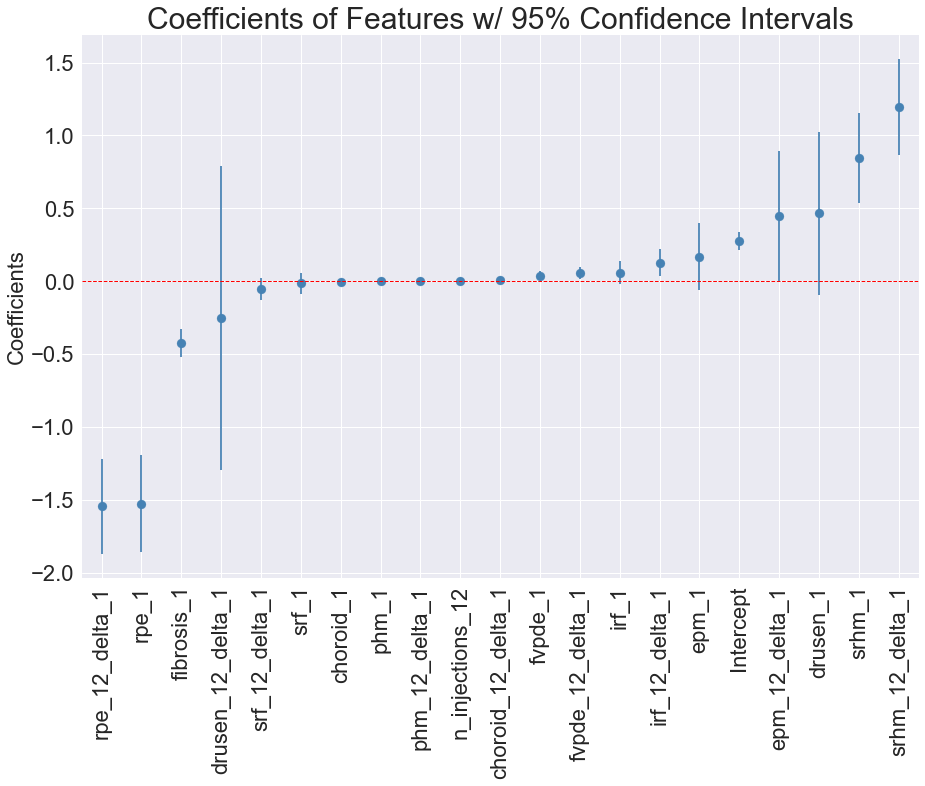

In [28]:
model_lin = sm.OLS.from_formula(f"y ~ {' + '.join(independent_variables)}", 
                                data=df_regression)

result_lin = model_lin.fit()

regression_summary = result_lin.summary()

reg_table = pd.read_html(result_lin.summary().tables[1].as_html(),header=0,index_col=0)[0]

# Plot coefficients w/95% confidence intervals for Model
coefplot(result_lin)

In [37]:
from statsmodels.tools.eval_measures import meanabs

X = df_regression[independent_variables]
y = df_regression["y"]

# now generate predictions
ypred = result_lin.predict(X)

# calc rmse
mae = meanabs(y, ypred)
mae_mean_predictor = meanabs(y, [y.mean()]*y.shape[0])

print("model mae is: ", mae, "mean predictor mae is: ", mae_mean_predictor)

model mae is:  0.17688936167768396 mean predictor mae is:  0.21527575789000844


Text(0.5, 1.0, 'mae decrease with time information')

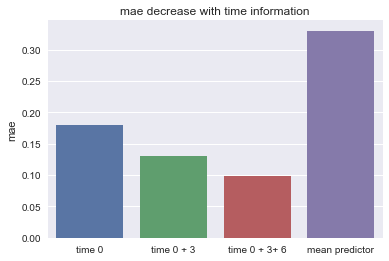

In [41]:
#### MAE plot
y = [0.18, 0.13, 0.098, 0.33]
x = ["time 0", "time 0 + 3", "time 0 + 3+ 6", "mean predictor"]
sns.barplot(x, y)
plt.ylabel("mae")
plt.title("mae decrease with time information")

Text(0.5, 1.0, 'R2 increase with time information')

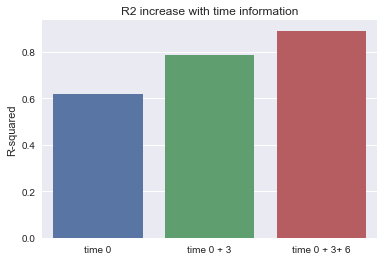

In [42]:
#### R2 plot
y = [0.616, 0.785, 0.89]
x = ["time 0", "time 0 + 3", "time 0 + 3+ 6"]
sns.barplot(x, y)
plt.ylabel("R-squared")
plt.title("R2 increase with time information")

## 3 month improvement groups

No handles with labels found to put in legend.


([<matplotlib.axis.XTick at 0x7fa3f4488750>,
 [Text(0, 0, 'x > 0'), Text(1, 0, '0 > x > - 0.2'), Text(2, 0, 'x < - 0.2')])

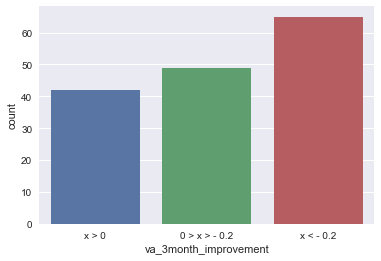

In [97]:
ax = sns.countplot(x="va_3month_improvement", data=abt_plt)
plt.legend()
plt.xticks(ticks=[0,1,2], labels=["x > 0", "0 > x > - 0.2", "x < - 0.2"])

Text(0.5, 0, 'Time')

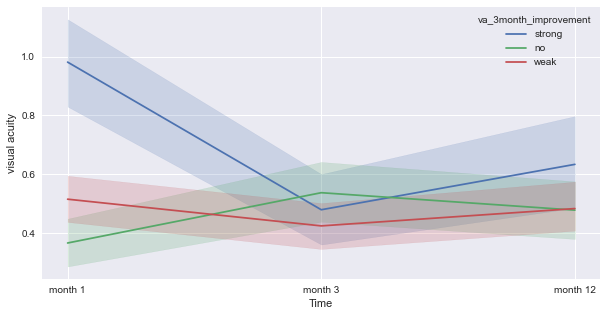

In [99]:
abt_plt = abt[["cur_va_rounded_1", "cur_va_rounded_3", "cur_va_rounded_12", "va_3_delta_1"]]

abt_plt["va_3month_improvement"] = None

strong_f = abt_plt["va_3_delta_1"] <= -0.2
weak_f = (abt_plt["va_3_delta_1"] <= 0) & (abt_plt["va_3_delta_1"] > -0.2)
no_f =  abt_plt["va_3_delta_1"] > 0

abt_plt["va_3month_improvement"][strong_f] = "strong"
abt_plt["va_3month_improvement"][weak_f] = "weak"
abt_plt["va_3month_improvement"][no_f] = "no"

abt_plt_long = abt_plt.melt(id_vars=["va_3month_improvement"], 
                            value_vars=["cur_va_rounded_1", "cur_va_rounded_3", "cur_va_rounded_12"])

dict_ = {'cur_va_rounded_1' : 'month 1', 'cur_va_rounded_3' : 'month 3', 'cur_va_rounded_12' : 'month 12'}

# Remap the values of the dataframe 
abt_plt_long = abt_plt_long.replace({"variable": dict_})

plt.figure(figsize=(10,5))
sns.lineplot(data=abt_plt_long, x="variable", y="value", hue="va_3month_improvement")
plt.ylabel("visual acuity")
plt.xlabel("Time")

Text(0.5, 1.0, 'no improvement')

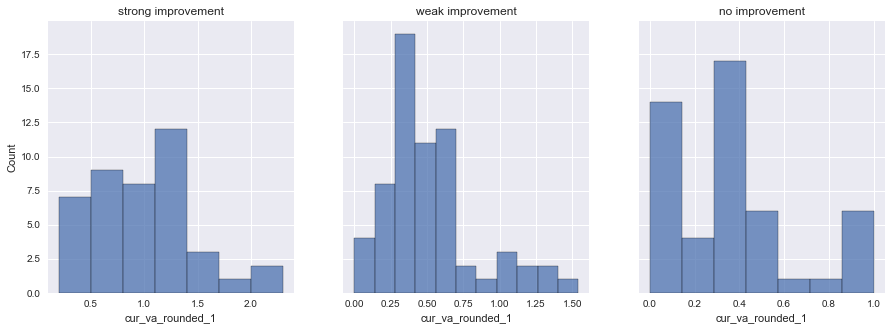

In [100]:

abt["regular_treatment"] = abt.n_injections_3 >= 3

abt["va_3month_improvement"] = None

strong_f = abt["va_3_delta_1"] <= -0.2
weak_f = (abt["va_3_delta_1"] <= 0) & (abt["va_3_delta_1"] > -0.2)
no_f =  abt["va_3_delta_1"] > 0

abt["va_3month_improvement"][strong_f] = 2
abt["va_3month_improvement"][weak_f] = 1
abt["va_3month_improvement"][no_f] = 0

abt["va_3month_improvement"] = abt["va_3month_improvement"].astype(int)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# strong
sns.histplot(ax=axes[0], x=abt[abt.va_3month_improvement == 2].cur_va_rounded_1)
axes[0].set_title("strong improvement")

# weak
sns.histplot(ax=axes[1], x=abt[abt.va_3month_improvement == 1].cur_va_rounded_1)
axes[1].set_title("weak improvement")

# no
sns.histplot(ax=axes[2], x=abt[abt.va_3month_improvement == 0].cur_va_rounded_1)
axes[2].set_title("no improvement")

## Seperating the non imporovers

In [122]:
abt_potential = abt[abt.cur_va_rounded_1 > 0.6]

no_improv = (((abt_potential.va_3month_improvement == 0) | (abt_potential.va_3month_improvement == 1)) & 
             (abt_potential.cur_va_rounded_1 > 0.6))

abt_potential["no_improvement_patients"] = no_improv

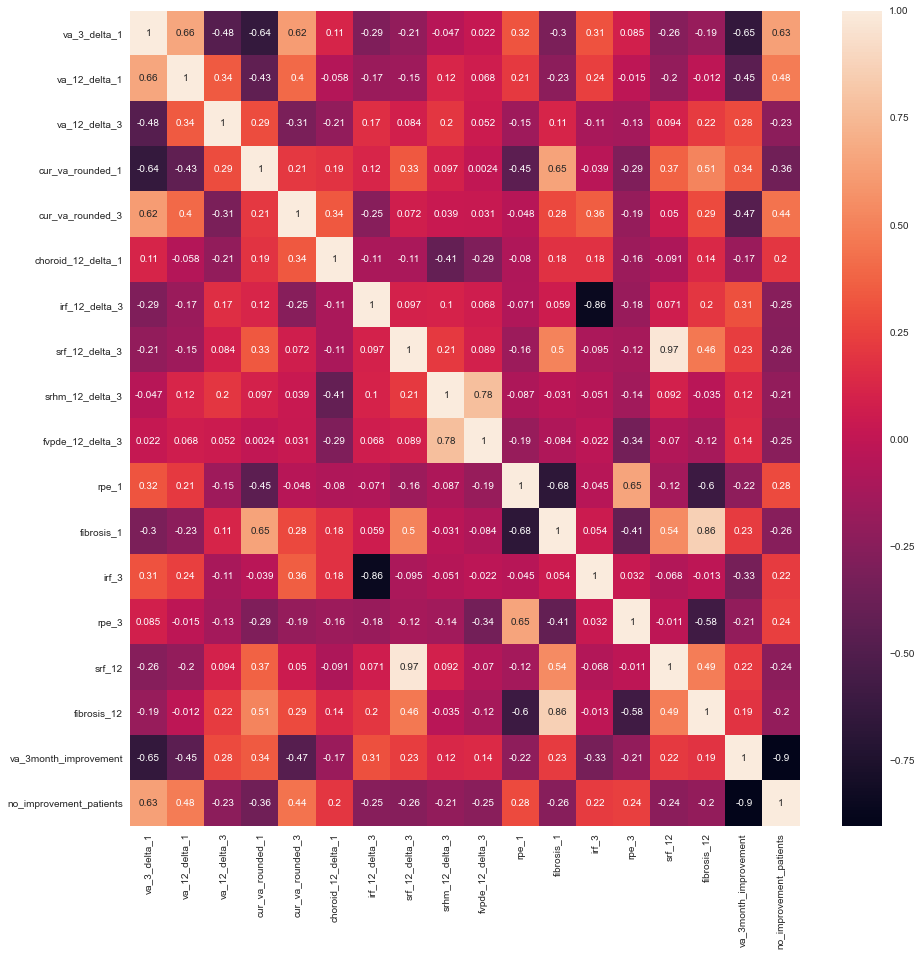

In [124]:
plt.figure(figsize=(15, 15))

corrMatrix = abt_potential.corr()

# filter corr table
corr_filter = np.abs(corrMatrix.loc["no_improvement_patients",:]) > 0.2

filtered_columns = filtered_columns = corrMatrix.columns[corr_filter.values].tolist()

corrMatrix_filtered = corrMatrix.loc[corr_filter.values, corr_filter.values]

sn.heatmap(corrMatrix_filtered, annot=True)
plt.show()